<img src="../images/vegan-logo-resized.png" style="float: right; margin: 10px;">

# Exploratory Data Analysis

Author: Gifford Tompkins

---

Project 03 | Notebook 2 of 6

## OBJECTIVE
This notebook will establish a Base Model to compare our final model's success to. We will then clean the data and make it ready fro analysis. We will then begin some Exploratory Data Analysis and attempt to get a sense of whether or not we will be able to answer our problem statement given our body of data. If so, we will also have a sense for how to develop a strategy for building our model.

# Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

from project_functions.model_tuning import condenser_tr, parse_performance

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [52]:
data_csv = '../data/data.csv'

# Exploratory Data Analysis
We are finished cleaning our data, so now we will explore it with some preliminary Vectorizations and develop a strategy for building our models.

In [53]:
eda = pd.read_csv(data_csv)
eda.head()

,title,selftext,vegan,removed,text
0,My ‘100 calories club’ which helps people visu...,NaN,0,0,my 100 calorie club which help people visuali...
1,Chilli fritters stuffed with a mix of raw onio...,NaN,0,0,chilli fritter stuffed with a mix of raw onion...
2,Lentil and mushroom gravy with sweetpotato mas...,NaN,0,0,lentil and mushroom gravy with sweetpotato mas...
3,How to get excited about vegetables?,I stopped eating meat after 24 years due to a ...,0,0,how to get excited about vegetable i stopped ...
4,Homemade Rasgulla - Bengali Spongy Milk Sweets...,NaN,0,0,homemade rasgulla bengali spongy milk sweet ...


In [54]:
eda['text'].isnull().mean()

0.0

## CountVectorizer
We will use a count vectorization to see if we can spot some features that will give us some signal and or detect some terms that are just giving us noise. For starters, we will give it the following parameters:
1. `stop_words` are english.
2. `ngram_range` from 1 to 2 word phrases.
3. `max_features` will be 2000.

In [55]:
cvec = CountVectorizer(stop_words='english',
                       ngram_range=(1,2),
                       max_features=2000)

In [56]:
term_cvec_matrix = cvec.fit_transform(eda['text'])

In [57]:
# Convert term matrix to a dataframe.
term_cvec_df = pd.DataFrame(term_cvec_matrix.toarray(), index=eda.index, columns=cvec.get_feature_names())

In [58]:
term_cvec_df.head()

,000,10,10 year,100,100 calorie,11,12,13,14,15,...,yesterday,yoghurt,yogurt,young,youtu,youtube,youtube com,yum,yummy,zucchini
0,0,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# Append the target column
term_cvec_df['vegan_target'] = eda['vegan']

In [60]:
term_cvec_df.head()

,000,10,10 year,100,100 calorie,11,12,13,14,15,...,yoghurt,yogurt,young,youtu,youtube,youtube com,yum,yummy,zucchini,vegan_target
0,0,0,0,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
cvec_terms_by_target = term_cvec_df.groupby(by='vegan_target').agg(np.mean).T.sort_values(by=0,ascending=False)
cvec_terms_by_target

vegan_target,0,1
vegetarian,0.476583,0.047347
meat,0.345857,0.184703
im,0.303654,0.268991
ha,0.286155,0.334547
wa,0.208441,0.240895
...,...,...
animal human,0.000000,0.005203
ignorance,0.000000,0.004162
animal testing,0.000000,0.005723
tail,0.000000,0.006243


###  CountVectorizer Signal Column
I am going to create a `'signal'` column that shows the difference in mean term frequency between the vegan posts and vegetarian posts. I will look at words with the highest signal for both r/Vegan and r/Vegetarian as well as some words that might be considered noise.

In [62]:
cvec_terms_by_target['signal'] = cvec_terms_by_target[1] - cvec_terms_by_target[0]
cvec_terms_by_target = cvec_terms_by_target.sort_values(by='signal',ascending=False)

In [63]:
vegan_terms_cv = cvec_terms_by_target.head(50).index
vegetarian_terms_cv = cvec_terms_by_target.tail(50).index
print(vegan_terms_cv)
print(vegetarian_terms_cv)

Index(['vegan', 'animal', 'people', 'milk', 'veganism', 'http', 'product',
       'human', 'ha', 'plant', 'dairy', 'www', 'cow', 'know', 'http www',
       'com', 'video', 'wa', 'doe', 'say', 'think', 'vegan diet', 'life',
       'diet', 'right', 'just', 'pet', 'need', 'change', 'world', 'industry',
       'friend', 'way', 'based', 'vegan food', 'killed', 'animal product',
       'x200b', 'non vegan', 'food', 'pain', 'non', 'wrong', 'going vegan',
       'went', 'dog', 'source', 'racist', 'bad', 'oat'],
      dtype='object')
Index(['favorite', 'lentil', 'fresh', 'sweet', 'delicious', 'lunch', 'onion',
       'cookbook', 'fry', 'eating meat', 'spicy', 'cheese', 'breakfast',
       'taco', 'idea', 'week', 'ingredient', 'mushroom', 'cooking',
       'ive vegetarian', 'pepper', 'red', 'vegetarian vegan', 'burger',
       'fried', 'vegetarianism', 'eating', 'dinner', 'ive', 'cook', 'dish',
       'deleted', 'homemade', 'eat', 'vegetable', 'im', 'sauce', 'tomato',
       'potato', 'chicken',

In [64]:
cvec_terms_by_target['signal'].describe()

count    2000.000000
mean        0.001012
std         0.022050
min        -0.429236
25%        -0.002042
50%         0.001063
75%         0.004164
max         0.732623
Name: signal, dtype: float64

> The words below might just be considered noise. They are the 100 words with the least amount of signal according to the CountVectorizer frequency.

In [65]:
cvec_term_mean = np.mean(cvec_terms_by_target['signal'])
cvec_term_std = np.std(cvec_terms_by_target['signal'])
cvec_noise = np.abs(cvec_terms_by_target['signal'] - cvec_term_mean).sort_values()[:100].index
cvec_noise

Index(['buffalo cauliflower', 'change diet', 'play', 'stuff like', 'did think',
       'aunt', 'newly', 'quarantine', 'tasting', 'physically', 'ive felt',
       'appetite', 'blueberry', 'bloating', 'consumed', '26', 'led',
       'supportive', 'im pretty', 'confused', 'color', 'vanilla', 'control',
       'regularly', 'class', 'cherry', 'spend', 'like eat', 'im currently',
       'html', 'love hear', 'imgur com', 'imgur', 'afraid', '40', 'ha best',
       'http imgur', 'grew', 'risk', 'acid', 'pressure', 'blog', 'necessary',
       'staying', 'regarding', 'price', 'party', 'smoothie', 'barely',
       'mentioned', 'force', 'clean', 'bone', 'unless', 'food eat', 'putting',
       'essential', 'subreddit', 'wa really', 'really want', 'specific',
       'concern', 'lover', 'seed', 'let know', 'moving', 'consider', 'awesome',
       'effect', 'meat eating', 'giving', 'totally', 'wanting', 'com poll',
       'view poll', 'learned', 'information', 'poll http', 'website', 'looked',
       'e

### Plot the Signal Words
Below is a heat map of the highest signal words.

<AxesSubplot:>

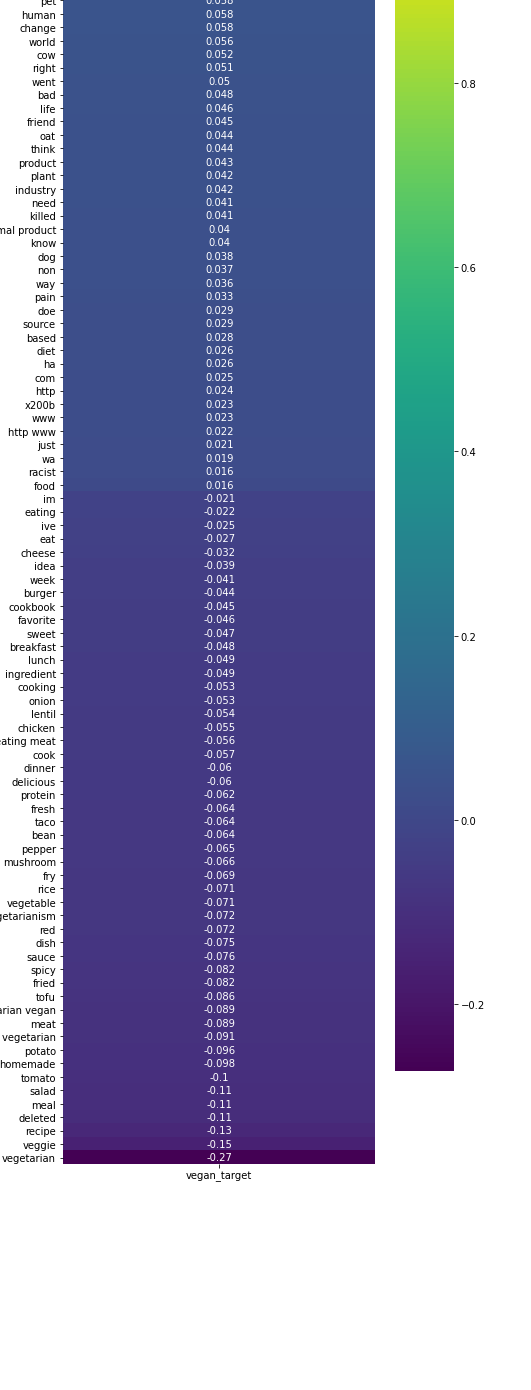

In [66]:
term_list_cv = [*vegan_terms_cv, *vegetarian_terms_cv, *['vegan_target']]

corr = term_cvec_df[term_list_cv].corr()[['vegan_target']].sort_values(by='vegan_target',
                                                               ascending=False)

plt.figure(figsize=(7,25))
sns.heatmap(corr,
            annot=True,
            cmap='viridis')

In [67]:
term_cvec_df[vegan_terms_cv].agg(np.sum)

vegan             1979
animal             664
people             425
milk               266
veganism           180
http               318
product            272
human              119
ha                1199
plant              228
dairy              180
www                164
cow                122
know               518
http www           159
com                194
video              103
wa                 868
doe                319
say                185
think              302
vegan diet          61
life               205
diet               380
right              156
just               800
pet                 57
need               229
change             122
world               96
industry            76
friend             155
way                250
based              204
vegan food          66
killed              52
animal product     100
x200b               88
non vegan           54
food               657
pain                58
non                129
wrong               67
going vegan

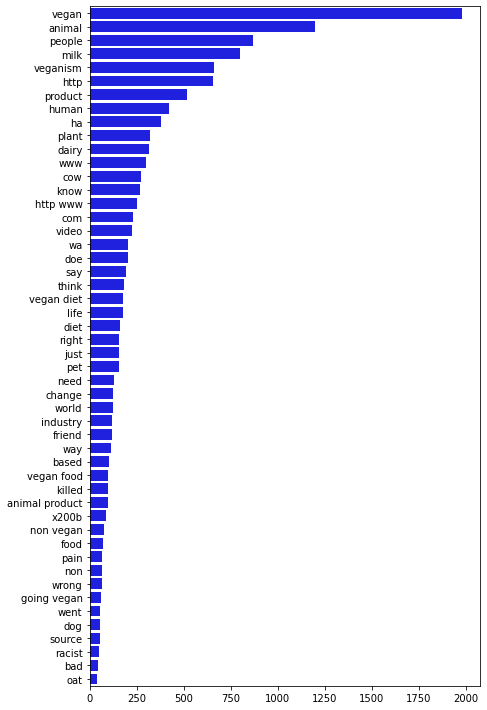

In [68]:
plt.figure(figsize=(7,12.5))
sns.barplot(x=term_cvec_df[vegan_terms_cv].agg(np.sum).sort_values(ascending=False),
            y=vegan_terms_cv,
            color='b',
            orient='h');

In [69]:
cvec_terms_by_target['class'] = cvec_terms_by_target['signal'].map(lambda x: 'vegan' if x > 0.001 else ('vegetarian' if x < -0.001 else 'ambiguous'))

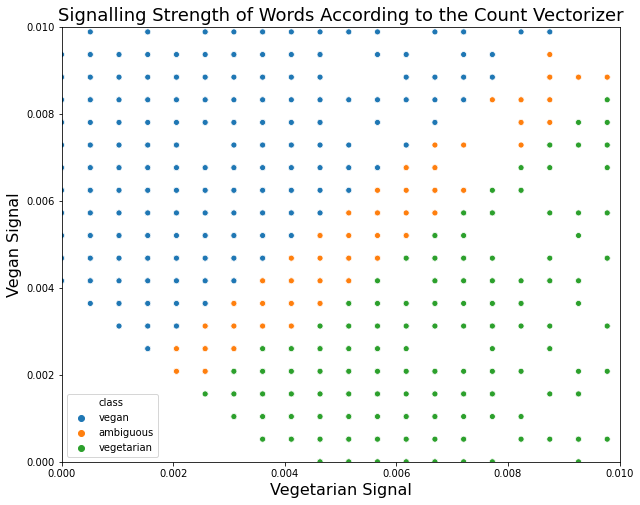

In [70]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=cvec_terms_by_target, x=0, y=1, hue='class')
plt.title('Signalling Strength of Words According to the Count Vectorizer', size=18)
plt.xlabel("Vegetarian Signal", size=16)
plt.ylabel("Vegan Signal", size=16)
plt.xlim((0,0.01))
plt.ylim((0,0.01))
plt.savefig('../images/vegan_v_vegetarian_signal.jpg')

## TFIDVectorizer
We will use a TF-IDF vectorization to see if we can spot some features that will give us some signal.

In [71]:
tfid = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2),
                       max_features=2000)

In [72]:
term_tfid_matrix = tfid.fit_transform(eda['text'])

In [73]:
# Convert term matrix to a dataframe.
term_tfid_df = pd.DataFrame(term_tfid_matrix.toarray(), index=eda.index, columns=cvec.get_feature_names())

In [74]:
term_tfid_df.head()

,000,10,10 year,100,100 calorie,11,12,13,14,15,...,yesterday,yoghurt,yogurt,young,youtu,youtube,youtube com,yum,yummy,zucchini
0,0.0,0.0,0.0,0.393224,0.496366,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Append the target column
term_tfid_df['vegan_target'] = eda['vegan']

In [76]:
term_tfid_df.head()

,000,10,10 year,100,100 calorie,11,12,13,14,15,...,yoghurt,yogurt,young,youtu,youtube,youtube com,yum,yummy,zucchini,vegan_target
0,0.0,0.0,0.0,0.393224,0.496366,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [77]:
tfid_terms_by_target = term_tfid_df.groupby(by='vegan_target').agg(np.mean).T.sort_values(by=0,ascending=False)
tfid_terms_by_target

vegan_target,0,1
vegetarian,0.054264,0.004141
recipe,0.028686,0.010147
meat,0.028438,0.022091
veggie,0.022651,0.002631
tofu,0.022475,0.005966
...,...,...
industry doe,0.000000,0.000125
dairy milk,0.000000,0.000960
ignorance,0.000000,0.001323
http pubmed,0.000000,0.000070


###  TfidfVectorizer Signal Column
I am going to create a `'signal'` column that shows the difference in mean TF-IDF score for the vegan posts and vegetarian posts. I will look at words with the highest signal for both r/Vegan and r/Vegetarian as well as some words that might be considered noise.

In [78]:
tfid_terms_by_target['signal'] = tfid_terms_by_target[1] - tfid_terms_by_target[0]
tfid_terms_by_target = tfid_terms_by_target.sort_values(by='signal',ascending=False)

In [79]:
vegan_terms_tf = tfid_terms_by_target.head(50).index
vegetarian_terms_tf = tfid_terms_by_target.tail(50).index
print(vegan_terms_cv)
print(vegetarian_terms_cv)

Index(['vegan', 'animal', 'people', 'milk', 'veganism', 'http', 'product',
       'human', 'ha', 'plant', 'dairy', 'www', 'cow', 'know', 'http www',
       'com', 'video', 'wa', 'doe', 'say', 'think', 'vegan diet', 'life',
       'diet', 'right', 'just', 'pet', 'need', 'change', 'world', 'industry',
       'friend', 'way', 'based', 'vegan food', 'killed', 'animal product',
       'x200b', 'non vegan', 'food', 'pain', 'non', 'wrong', 'going vegan',
       'went', 'dog', 'source', 'racist', 'bad', 'oat'],
      dtype='object')
Index(['favorite', 'lentil', 'fresh', 'sweet', 'delicious', 'lunch', 'onion',
       'cookbook', 'fry', 'eating meat', 'spicy', 'cheese', 'breakfast',
       'taco', 'idea', 'week', 'ingredient', 'mushroom', 'cooking',
       'ive vegetarian', 'pepper', 'red', 'vegetarian vegan', 'burger',
       'fried', 'vegetarianism', 'eating', 'dinner', 'ive', 'cook', 'dish',
       'deleted', 'homemade', 'eat', 'vegetable', 'im', 'sauce', 'tomato',
       'potato', 'chicken',

In [80]:
tfid_terms_by_target['signal'].describe()

count    2000.000000
mean       -0.000050
std         0.002725
min        -0.050122
25%        -0.000494
50%         0.000090
75%         0.000666
max         0.073706
Name: signal, dtype: float64

> The words below might just be considered noise. They are the 100 words with the least amount of signal according to the CountVectorizer frequency.

In [81]:
tfid_term_mean = np.mean(tfid_terms_by_target['signal'])
tfid_term_std = np.std(tfid_terms_by_target['signal'])
tfid_noise = np.abs(tfid_terms_by_target['signal'] - tfid_term_mean).sort_values()[:100].index
tfid_noise

Index(['im sorry', 'likely', 'shake', 'struggling', 'turkey', 'asked',
       'answer', 'boiling', 'www ncbi', 'pmc', 'gov pmc', 'pmc article',
       'looking', 'accidentally', 'bag', 'heavy', 'progress', 'causing',
       'just like', 'grown', 'caused', 'color', 'learn', 'blood test',
       'frequently', 'cholesterol', 'basically', 'bulk', 'ordered',
       'meat consumption', 'difficult', 'boring', 'really want', 'star',
       'format', 'childhood', 'began', 'did think', 'package',
       'looking advice', 'wa going', 'flavoring', 'ive trying', 'later',
       'compare', 'finish', 'wonderful', 'week ago', 'similar', 'son',
       'feel better', 'kind', 'unfortunately', 'trouble', 'active', 'set',
       'anyways', 'tend', 'im sure', 'stick', 'taste good', 'just wanted',
       'boil', 'year ive', 'know im', 'multivitamin', 'rest', 'kept', 'ur',
       'year old', 'confused', 'ethical reason', 'eaten', 'year ago',
       'research', 'make sense', 'produce', 'gut', 'nutritional yeas

### Plot the Signal Words
Below is a heat map of the highest signal words.

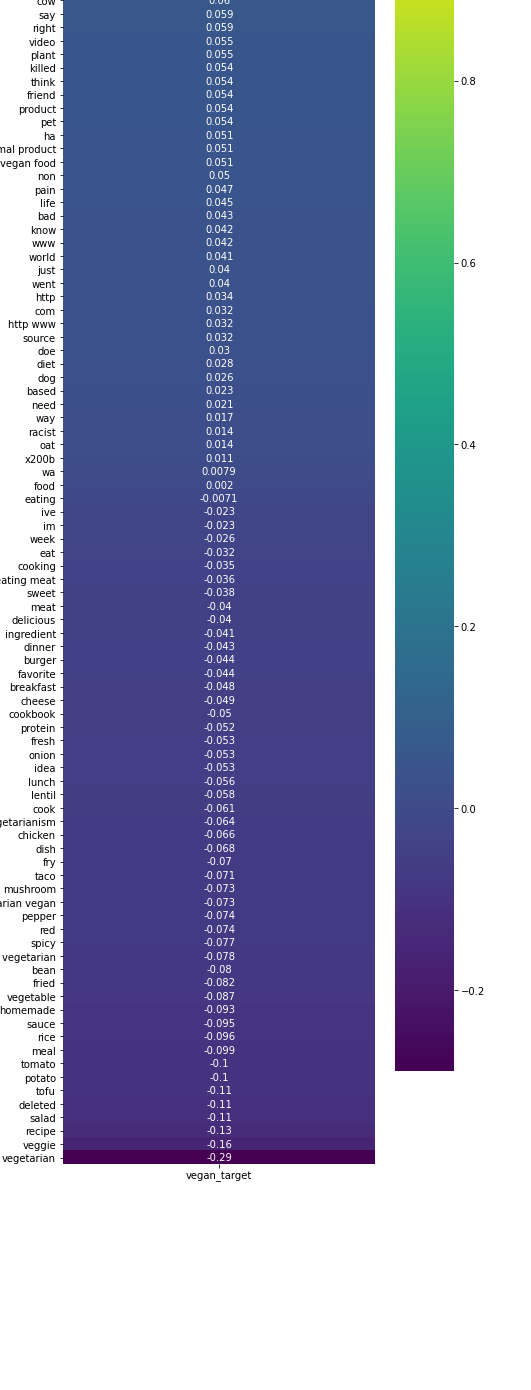

In [110]:
term_list_cv = [*vegan_terms_cv, *vegetarian_terms_cv, *['vegan_target']]

corr = term_tfid_df[term_list_cv].corr()[['vegan_target']].sort_values(by='vegan_target',
                                                               ascending=False)

plt.figure(figsize=(7,25))
sns.heatmap(corr,
            annot=True,
            cmap='viridis');
# Click the image for full-size.

In [106]:
term_tfid_df[vegan_terms_cv].agg(np.sum)[:10]

vegan       204.868745
animal       63.153262
people       40.487585
milk         30.634806
veganism     28.623913
http         23.732044
product      25.665129
human        16.307282
ha           86.336360
plant        31.054381
dtype: float64

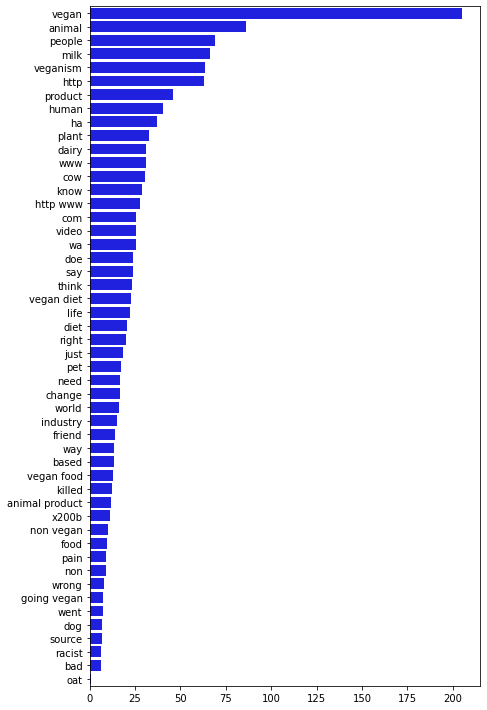

In [105]:
plt.figure(figsize=(7,12.5))
sns.barplot(x=term_tfid_df[vegan_terms_cv].agg(np.sum).sort_values(ascending=False),
            y=vegan_terms_cv,
            color='b',
            orient='h');

In [104]:
signal_terms = set([*vegan_terms_cv, 
    *vegan_terms_tf,
    *vegetarian_terms_cv, 
    *vegetarian_terms_tf
])
list(signal_terms)[:20]

['dinner',
 'ramen',
 'pet',
 'paneer',
 'fry',
 'roasted',
 'sauce',
 'eating meat',
 'cauliflower',
 'industry',
 'vegan',
 'ingredient',
 'vegetable',
 'recipe comment',
 'need',
 'http',
 'ha',
 'protein',
 'ive vegetarian',
 'zucchini']

In [86]:
mms = MinMaxScaler()
tfid_df = pd.DataFrame(tfid_terms_by_target['signal'],index=tfid_terms_by_target.index)
tfid_df['signal'] = mms.fit_transform(tfid_df[['signal']])
tfid_df.columns = ['tfid_signal']
tfid_df

,tfid_signal
vegan,1.000000
animal,0.559430
veganism,0.508485
people,0.490086
milk,0.464650
...,...
deleted,0.286089
tofu,0.271447
recipe,0.255055
veggie,0.243094


In [87]:
cvec_df = pd.DataFrame(cvec_terms_by_target['signal'],index=cvec_terms_by_target.index)
cvec_df['signal'] = mms.fit_transform(cvec_df[['signal']])
cvec_df.columns = ['cvec_signal']
cvec_df

,cvec_signal
vegan,1.000000
animal,0.548311
people,0.451083
milk,0.436000
veganism,0.435792
...,...
meal,0.289225
veggie,0.286783
recipe,0.266818
meat,0.230736


# Model: Count Vectorizer

We will create a quick model here using the CountVectorizer and the Multinomial Naive Bayes estimator. We use the MultinomialNB because our values will be nonnegative integers after the CountVectorizer transforms our data.

We will also use a GridSearchCV to find the best parameters with which to tune our CountVectorizer.

In [88]:
pipe_cv = Pipeline([
    ('vec',CountVectorizer()),
    ('estimator', MultinomialNB())
])

In [89]:
X = eda['text']
y = eda['vegan']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

## Pipe Parameters

In [90]:
pipe_params = {
    'vec__max_features':[1000, 2000, 5000],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95, 1.0],
    'vec__ngram_range': [(1,1), (1,2), (1,3)]
}

In [91]:
t_0 = time.time()
gs_cv = GridSearchCV(pipe_cv,
                     pipe_params,
                     cv=5,
                     n_jobs=-1                     
                 )
gs_cv.fit(X_train, y_train)

print(time.time() - t_0)

22.68194890022278


In [92]:
gs_cv.best_score_

gs_cv.best_params_

model_cv = gs_cv.best_estimator_
print(f"Training Score: {model_cv.score(X_train, y_train)}")
print(f"Testing score: {model_cv.score(X_test, y_test)}")

Training Score: 0.8436853002070394
Testing score: 0.7911065149948294


> Our model is slightly overfit, but already there is a **50% improvement** from our baseline model.

# Model: TfidfVectorizer and GaussianNB
For the TfidfVectorizer, we have to use the Gaussian Naive Bayes estimator, because our vectorizer outputs float values between 0 and 1. The vectorizer also puts out a sparse matrix, so we will use a custom function called `condenser_tr` to transform it into a dense matrix.

To see the custom function documentation, look [here](./project_functions/model_tuning.py).

In [93]:
# Create pipe-grid for TfidVectorizer()
pipe_tf = Pipeline([
    ('vec',TfidfVectorizer()),
    ('to_dense',condenser_tr),
    ('gaus',GaussianNB())
])

In [94]:
pipe_params = {
    'vec__max_features':[1000, 2000, 5000],
    'vec__min_df':[2, 3],
    'vec__max_df':[0.90, 0.95],
    'vec__ngram_range': [(1,1), (1,2)]
}

In [95]:
t_0 = time.time()
gs_tf = GridSearchCV(pipe_tf,
                     pipe_params,
                     cv=5,
                     n_jobs=-1)
gs_tf.fit(X_train, y_train)

print(time.time() - t_0)

11.509271144866943


In [96]:
gs_tf.best_score_

0.6825352867607648

In [97]:
gs_tf.best_params_

{'vec__max_df': 0.9,
 'vec__max_features': 2000,
 'vec__min_df': 3,
 'vec__ngram_range': (1, 2)}

In [98]:
model_tf = gs_tf.best_estimator_
model_tf.score(X_train, y_train)

0.8440303657694962

In [99]:
model_tf.score(X_test, y_test)

0.7083764219234746

## Evaluate first models
Finally, we will see which model gave us a better sensitivity and specificity score using the custom function `parse_performance`, whose documentation can be found [here](./project_functions/model_tuning.py).

In [100]:
parse_performance(gs_cv, X_test, y_test)

(0.7394957983193278, 0.8411405295315683, (413, 78, 124, 352))

In [101]:
parse_performance(gs_tf, X_test, y_test)

(0.6302521008403361, 0.7841140529531568, (385, 106, 176, 300))

> Given the current parameters, the CountVectorizer gives us a higher specificity score.

# Summary
In this notebook we did some exploratory data analysis and looked at some of our highest signaling words, as well as the comparative performance of the TfidfVectorizer against the CountVectorizer for our future models.

In the next notebook we will create our models and find the ones that perform best for our objective of creating a model with high accuracy, optimizing for sensitivity.